In [69]:
import numpy as np
import pandas as pd
import importlib
import random
import simulate_data
from simulation_evaluation import run_test, plot_mse, get_conf_intervals, plot_gain_curves
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest

from matplotlib import pyplot as plt

importlib.reload(simulate_data)

<module 'simulate_data' from 'D:\\Delft\\Year 3\\Q4\\code\\research-project\\simulate_data.py'>

In [70]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)

xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 1 if x == False else 0, y))

xs = xs.drop(columns=["id", "mort_28", "peep", "peep_regime"])
columns_x = xs.columns

xs.loc[xs["sex"] == "M", "sex"] = 0
xs.loc[xs["sex"] == "F", "sex"] = 1

norm_xs = (xs - xs.mean())/xs.std()

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,0.732971,1.191182,0.183841,-0.123443,-0.026374,-0.049713,-1.422636,-1.225725,-0.364306,-0.580942,...,-1.048713,-0.897592,-0.564826,-1.945761,1.474415,-0.543738,0.705302,-0.416477,-0.675390,0.464621
1,-1.005004,-0.839289,1.422974,1.198448,-0.637005,-0.385550,-0.768253,-1.823462,-1.141620,1.996152,...,-1.629822,2.693985,0.758913,-1.800247,1.474372,3.032717,-0.620678,-0.199109,-0.769333,0.447981
2,1.353676,-0.839289,-0.381057,0.052809,-0.171336,-0.406111,-0.403630,1.164175,1.468983,-0.468897,...,-0.668334,0.703662,-0.434729,0.188444,-1.071592,-0.035368,0.317210,-1.156597,-0.593191,-1.354663
3,1.353676,-0.839289,0.100018,0.052809,-0.319055,-1.169822,-0.403630,1.901629,1.395651,-0.811559,...,0.023680,1.738181,-1.503965,0.964519,-1.046993,-0.868889,0.640620,-0.593435,-0.236013,-1.365063
4,0.050195,-0.839289,-0.654395,1.198448,-0.577049,-0.737052,-0.334933,0.672538,-1.072479,0.565211,...,2.898673,-0.720674,-0.385943,-0.070247,-0.851941,-1.051634,-1.236080,-1.350927,-0.510105,-0.435811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,1.191182,-1.128181,-0.828452,-0.711144,0.068026,-0.395043,0.314053,1.219655,-0.814377,...,0.112283,0.478767,0.541000,-0.005574,0.373186,-0.428608,0.252528,-0.955742,-0.205677,-0.683525
3937,0.732971,-0.839289,0.475402,0.757817,-0.527518,-0.793421,-0.300585,-0.433644,-0.540301,0.012723,...,-1.092709,2.250942,-0.411497,-0.859256,-1.612986,-0.966353,-1.028174,-0.927655,-0.702715,-0.705604
3938,0.236407,1.191182,0.438957,-0.387822,-0.701828,-0.554080,0.137359,-0.648735,0.281012,-0.869185,...,1.026414,0.532742,1.377339,-0.626434,1.846693,-0.299739,1.869576,1.093747,-0.605551,-0.248263
3939,0.298477,-0.839289,0.245798,-0.564074,-0.425805,-0.814696,-0.156321,0.844611,0.075683,-0.444100,...,-0.423609,-0.522017,0.150708,0.285454,-1.309207,-0.298318,0.113924,0.199255,2.694801,1.737565


In [71]:
full_data = imp_xs.assign(W=w, Y=y)

In [72]:
lin_reg_0 = LinearRegression()
lin_reg_0.fit(X=full_data.query("W==0")[columns_x].values, y=full_data.query("W==0")["Y"])

lin_reg_1 = LinearRegression()
lin_reg_1.fit(X=full_data.query("W==1")[columns_x].values, y=full_data.query("W==1")["Y"])

# lin_reg_0.predict(full_data[columns_x].values)

LinearRegression()

In [73]:
knn_0 = KNeighborsRegressor(n_neighbors=5)
knn_1 = KNeighborsRegressor(n_neighbors=5)

knn_0.fit(X=full_data.query("W==0")[columns_x].values, y=full_data.query("W==0")["Y"])
knn_1.fit(X=full_data.query("W==1")[columns_x].values, y=full_data.query("W==1")["Y"])

# knn_0.predict(full_data[columns_x].values)

KNeighborsRegressor()

In [74]:
tree_0 = DecisionTreeRegressor(min_samples_leaf=15)
tree_1 = DecisionTreeRegressor(min_samples_leaf=15)

tree_0.fit(X=full_data.query("W==0")[columns_x].values, y=full_data.query("W==0")["Y"])
tree_1.fit(X=full_data.query("W==1")[columns_x].values, y=full_data.query("W==1")["Y"])

# tree_0.predict(full_data[columns_x].values)

DecisionTreeRegressor(min_samples_leaf=15)

In [76]:
d = 23
vars = random.sample(range(d), k=5)
e = lambda x: 0.025 + sum(list(map(lambda v: 0.04 if x[v] * ((-1) ** (v+1)) >=0 else 0, vars)))
mu_0 = lambda x: np.mean([lin_reg_0.predict(np.reshape(x, (1,-1)))[0], knn_0.predict(np.reshape(x, (1,-1)))[0], tree_0.predict(np.reshape(x, (1,-1)))[0]])
mu_1 = lambda x: np.mean([lin_reg_1.predict(np.reshape(x, (1,-1)))[0], knn_1.predict(np.reshape(x, (1,-1)))[0], tree_1.predict(np.reshape(x, (1,-1)))[0]])
n_train = 40000
n_test = 10000
reps = 50

In [77]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

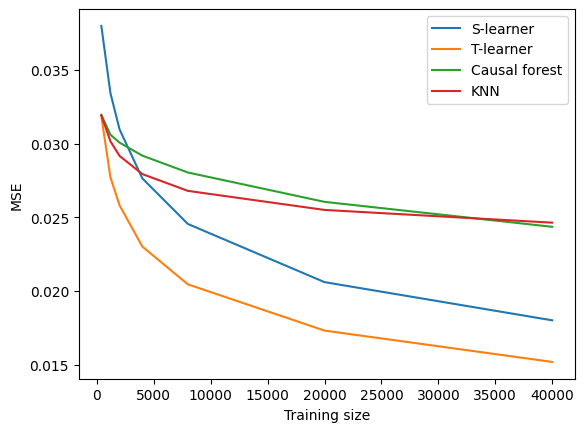

In [78]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [79]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,0.018008,0.000528
T-Learner,0.015186,0.000302
Causal Forest,0.024352,0.000396
KNN,0.024633,0.000386


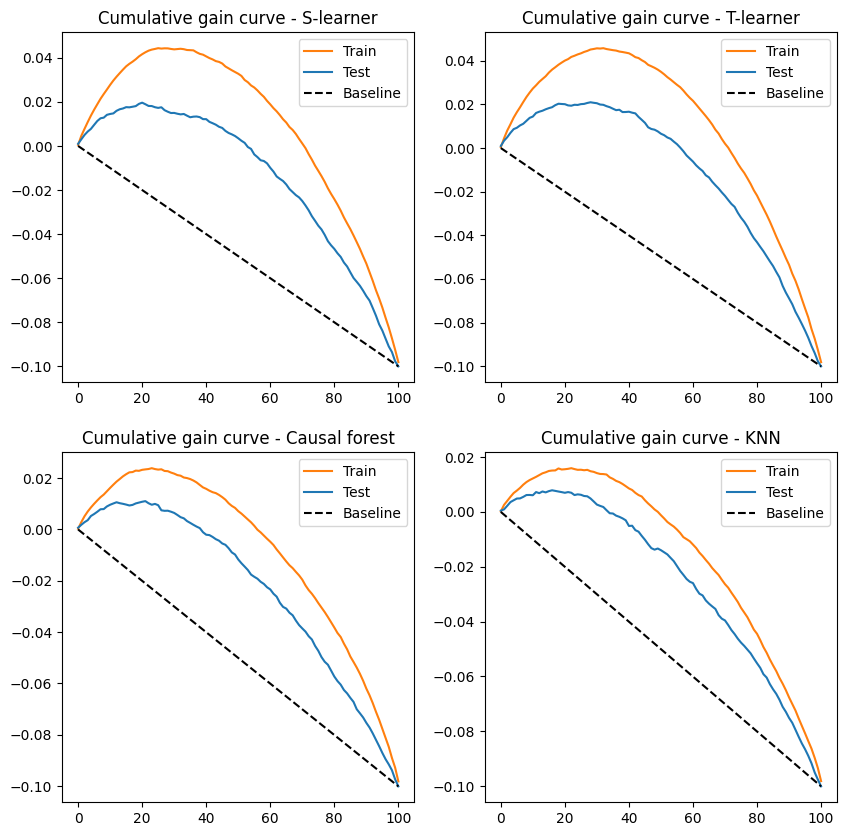

In [80]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)